#MARALIA PARASITE DETECTION USING AUTOENCODERS | BAKPEN KOMBAT
This project uses a Convolutional Autoencoder (CAE) and Kernel Density Estimation (KDE) to detect parasitized cells in blood smear images. The CAE is trained on uninfected cells to learn their normal patterns. Then, by analyzing the reconstruction error and density score in the latent space generated by the CAE and KDE respectively, it identifies parasitized cells as anomalies due to their higher reconstruction errors and lower density compared to uninfected cells. The system's performance is evaluated with ROC curves and AUC score.

**LIBARIES**

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.neighbors import KernelDensity
from google.colab import drive

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


import os
import shutil
import random

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

**Import data**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Divide data

In [ ]:


source_folder = "/content/drive/MyDrive/Machine Learning /data/Uninfected"
destination_folder_1 = os.path.join(source_folder, "cells1")
destination_folder_2 = os.path.join(source_folder, "cells2")

os.makedirs(destination_folder_1, exist_ok=True)
os.makedirs(destination_folder_2, exist_ok=True)

all_files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

random.shuffle(all_files)

split_index = int(len(all_files) * 0.4)

for file in all_files[:split_index]:
    shutil.move(os.path.join(source_folder, file), os.path.join(destination_folder_1, file))

for file in all_files[split_index:]:
    shutil.move(os.path.join(source_folder, file), os.path.join(destination_folder_2, file))

print("Images moved successfully!")


Images moved successfully!


In [ ]:

batch_size = 32
SIZE = 128


**DATA GENERATOR**

In [ ]:
# Define the custom generator
def autoencoder_generator(generator):
    """Custom generator for autoencoder that yields (x, y) pairs where x == y"""
    for batch in generator:
        yield (batch, batch)


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator for uninfected images
train_generator_raw = datagen.flow_from_directory(
    '/content/drive/MyDrive/Machine Learning /data/Uninfected/',
    classes=['cell1'],
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    subset='training'
)

# Validation generator for uninfected images
validation_generator_raw = datagen.flow_from_directory(
    '/content/drive/MyDrive/Machine Learning /data/Uninfected/',
    classes=['cell2'],
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    subset='validation'
)

# Wrapping the raw generators with the autoencoder generator
train_generator = autoencoder_generator(train_generator_raw)
validation_generator = autoencoder_generator(validation_generator_raw)

# Anomaly generator for parasitized images
anomaly_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Machine Learning /data/Parasitized/',
    classes=['.'],
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode=None,
    shuffle=True
)


anomaly_generator = autoencoder_generator(anomaly_generator)


Found 4216 images belonging to 1 classes.
Found 1581 images belonging to 1 classes.
Found 13707 images belonging to 1 classes.


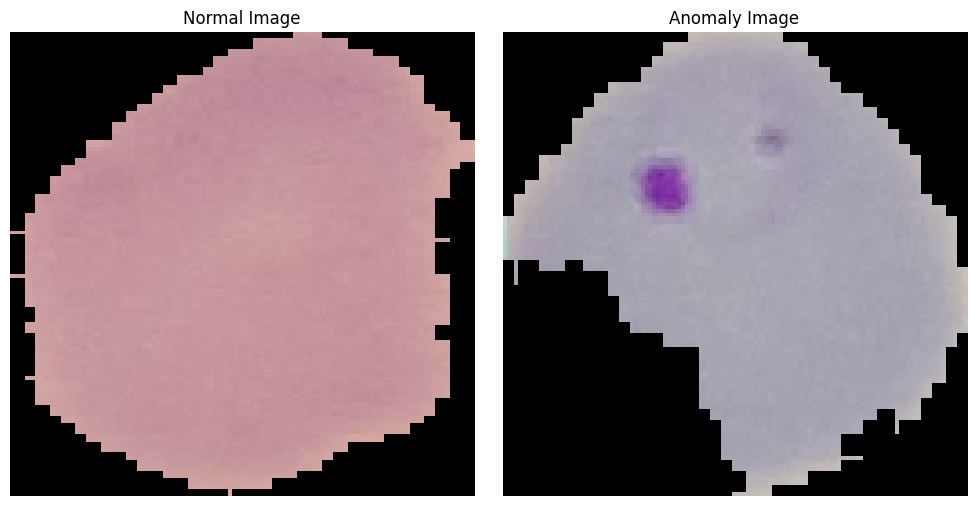

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of normal images
normal_batch = next(train_generator)[0]
normal_image = normal_batch[0]

anomaly_batch = next(anomaly_generator)[0]
anomaly_image = anomaly_batch[0]


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Normal image
axes[0].imshow(normal_image)
axes[0].set_title("Normal Image")
axes[0].axis("off")

# Anomaly image
axes[1].imshow(anomaly_image)
axes[1].set_title("Anomaly Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

**AUTOENCODER ARCHITECTURE**

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,067 (203.39 KB)

 Trainable params: 52,067 (203.39 KB)

 Non-trainable params: 0 (0.00 B)

**TRAINING**

In [ ]:
#Fit the model.
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.0861 - mse: 0.0861 - val_loss: 0.0397 - val_mse: 0.0397
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 846ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 835ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 881ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 573ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 814ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 702ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 671ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 929ms/step 

**PERFORMORMANCE EVALUATION**

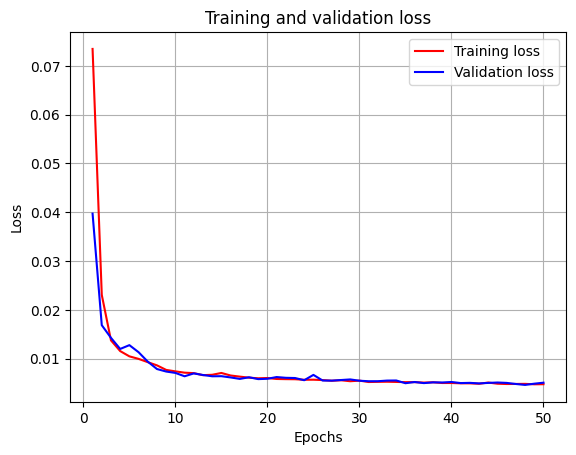

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**PREDICTION**

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step


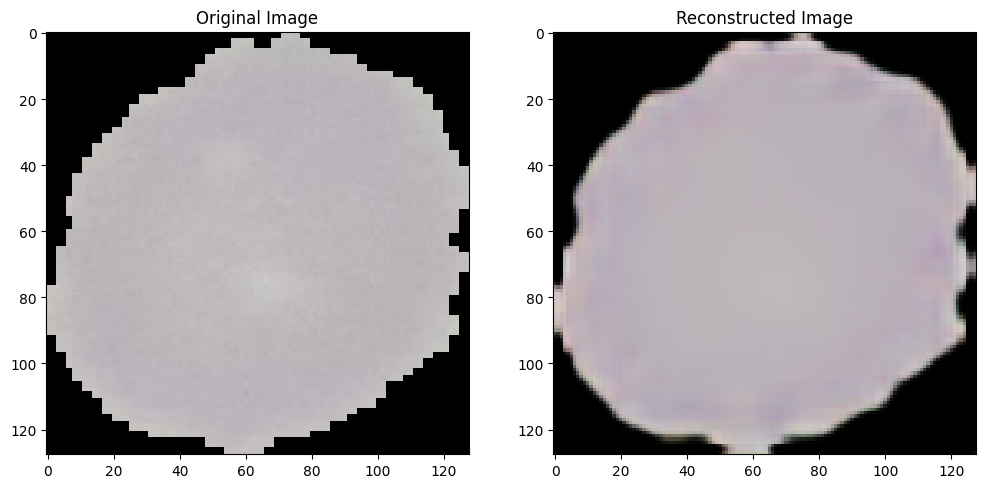

In [ ]:
data_batch = []
batch_count = 0
max_batches = 10

# Loop over the generator to capture batches
for data in train_generator:
    data_batch.append(data[0])
    batch_count += 1
    if batch_count >= max_batches:
        break

# Convert data_batch to a single numpy array for prediction
data_batch = np.concatenate(data_batch, axis=0)

# Predict on the first batch of images
predicted = model.predict(data_batch)

# Sanity check: view a few images and their corresponding reconstructions
image_number = random.randint(0, predicted.shape[0] - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(data_batch[image_number])
plt.subplot(122)
plt.title("Reconstructed Image")
plt.imshow(predicted[image_number])
plt.show()


**RECONSTRUCTION LOSS**

In [ ]:
validation_error = model.evaluate(validation_generator, steps=75 // batch_size)
anomaly_error = model.evaluate(anomaly_generator, steps=75 // batch_size)

print("Reconstruction error for the validation (normal) data is: ", validation_error)
print("Reconstruction error for the anomaly data is: ", anomaly_error)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0048 - mse: 0.0048
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0054 - mse: 0.0054
Reconstruction error for the validation (normal) data is:  [0.00487132091075182, 0.00487132091075182]
Reconstruction error for the anomaly data is:  [0.005496207624673843, 0.005496207159012556]


**SECOND PART**

In [ ]:
encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
encoder_model.layers[0].set_weights(model.layers[0].get_weights())
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
encoder_model.layers[2].set_weights(model.layers[2].get_weights())
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
encoder_model.layers[4].set_weights(model.layers[4].get_weights())
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,880 (97.19 KB)

 Trainable params: 24,880 (97.19 KB)

 Non-trainable params: 0 (0.00 B)

# KDE

In [ ]:


def get_encoded_images(generator, encoder_model, batch_size, max_batches):
    """Retrieve and encode images from the generator in batches."""
    encoded_images = []
    batch_count = 0

    while batch_count < max_batches:
        try:
            batch = next(generator)
            images = batch[0]
            encoded_images_batch = encoder_model.predict(images)
            encoded_images.append(encoded_images_batch)
            batch_count += 1
        except StopIteration:
            break

    # Concatenate all the encoded images into a single array
    return np.concatenate(encoded_images, axis=0)


batch_size = 8
max_batches = 10


encoded_images = get_encoded_images(train_generator, encoder_model, batch_size, max_batches)

# Flatten the encoder output
encoder_output_shape = encoder_model.output_shape
out_vector_shape = encoder_output_shape[1] * encoder_output_shape[2] * encoder_output_shape[3]
encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

# Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

# Function to calculate density and reconstruction error for each image
def calc_density_and_recon_error(batch_images):
    density_list = []
    recon_error_list = []

    for im in range(batch_images.shape[0]):
        img = batch_images[im]
        img = img[np.newaxis, :, :, :]
        encoded_img = encoder_model.predict(img)
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]
        density = kde.score_samples(encoded_img)[0]  # Get density score
        reconstruction = model.predict(img)
        reconstruction_error = model.evaluate(reconstruction, img, batch_size=1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)

    # Calculate averages and standard deviations
    average_density = np.mean(np.array(density_list))
    stdev_density = np.std(np.array(density_list))
    average_recon_error = np.mean(np.array(recon_error_list))
    stdev_recon_error = np.std(np.array(recon_error_list))

    return average_density, stdev_density, average_recon_error, stdev_recon_error

# Limit the number of batches for the training and anomaly data
train_batch = next(train_generator)[0]
anomaly_batch = next(anomaly_generator)[0]

# Calculate density and reconstruction errors for uninfected and anomaly images
uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0071 - mse: 0.0071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0069 - mse: 0.0069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0046 - mse: 0.0046
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0090 - mse: 0.0090
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━

# TEST RESULTS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0079 - mse: 0.0079
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0079 - mse: 0.0079
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0076 - mse: 0.0076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0072 - mse: 0.0072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0071 - mse: 0.0071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0099 - mse: 0.0099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0107 - mse: 0.0107

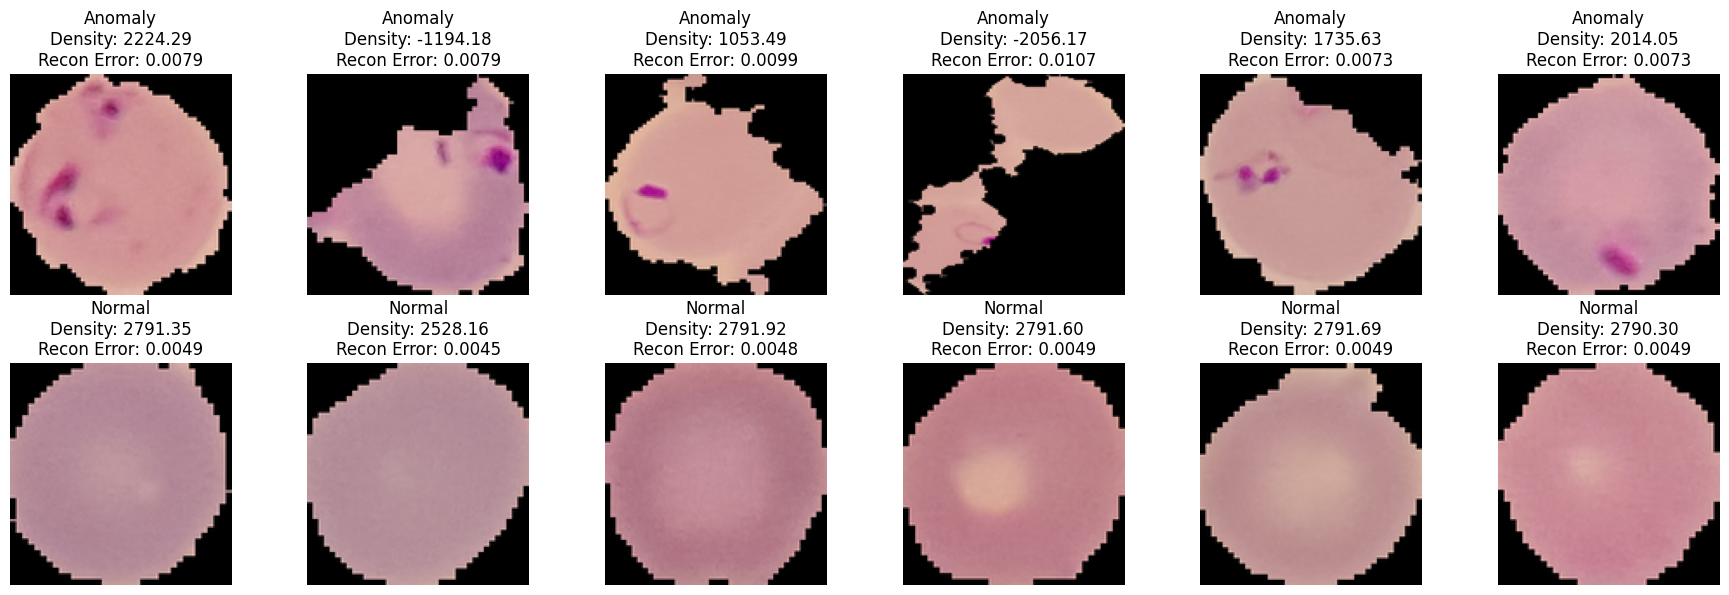

In [ ]:


def check_anomaly(img_path):
    density_threshold = 2500
    reconstruction_error_threshold = 0.005
    img = Image.open(img_path)
    img_resized = np.array(img.resize((128, 128), Image.Resampling.LANCZOS))

    img_resized = img_resized / 255.0
    img_resized = img_resized[np.newaxis, :, :, :]

    # Predict the encoded image
    encoded_img = encoder_model.predict(img_resized)
    encoded_img = [np.reshape(img_resized, (out_vector_shape)) for img_resized in encoded_img]

    # Calculate density
    density = kde.score_samples(encoded_img)[0]

    # Predict reconstruction
    reconstruction = model.predict(img_resized)
    reconstruction_error = model.evaluate(reconstruction, img_resized, batch_size=1)[0]

    return density, reconstruction_error

# Paths to the image datasets
para_file_paths = glob.glob('/content/drive/MyDrive/Machine Learning /data/Parasitized/*')
uninfected_file_paths = glob.glob('/content/drive/MyDrive/Machine Learning /data/Uninfected/cell2/*')


valid_anomalies = []
valid_normals = []

for img_path in para_file_paths:
    density, recon_error = check_anomaly(img_path)
    if recon_error > 0.005 and density < 2500:
        valid_anomalies.append((img_path, density, recon_error))
    if len(valid_anomalies) >= 6:
        break


for img_path in uninfected_file_paths:
    density, recon_error = check_anomaly(img_path)
    if recon_error <= 0.005 and density >= 2500:
        valid_normals.append((img_path, density, recon_error))
    if len(valid_normals) >= 6:
        break


fig, axes = plt.subplots(2, 6, figsize=(18, 6))

# Plot 6 anomalies
for i, (img_path, density, recon_error) in enumerate(valid_anomalies):
    img = Image.open(img_path).resize((128, 128), Image.Resampling.LANCZOS)
    axes[0, i].imshow(np.array(img))
    axes[0, i].set_title(f"Anomaly\nDensity: {density:.2f}\nRecon Error: {recon_error:.4f}")
    axes[0, i].axis('off')

# Plot 6 normals
for i, (img_path, density, recon_error) in enumerate(valid_normals):
    img = Image.open(img_path).resize((128, 128), Image.Resampling.LANCZOS)
    axes[1, i].imshow(np.array(img))
    axes[1, i].set_title(f"Normal\nDensity: {density:.2f}\nRecon Error: {recon_error:.4f}")
    axes[1, i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


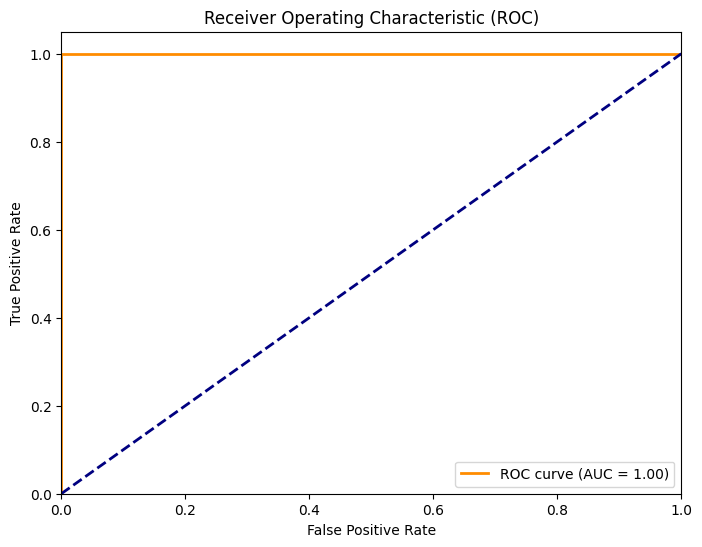

In [ ]:

normal_recon_errors = uninfected_values[2]
anomalous_recon_errors = anomaly_values[2]
normal_density_scores = uninfected_values[0]
anomalous_density_scores = anomaly_values[0]


recon_errors = [normal_recon_errors] * len(train_batch) + [anomalous_recon_errors] * len(anomaly_batch)
density_scores = [normal_density_scores] * len(train_batch) + [anomalous_density_scores] * len(anomaly_batch)


labels = [0] * len(train_batch) + [1] * len(anomaly_batch)


scores = recon_errors
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
